# Applying Vectorization to speed up Pandas

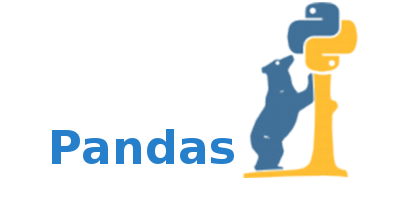

Like many other libraries - Pandas has built in access to Numpy. And there are many ways to accomplish any given task in Pandas. 

# Learning Objectives:
- Apply Numpy methods to dramatically speed up certain common Pandas bottlenecks
- Apply WHERE or SELECT in Numpy powered by oneAPI
- Avoid **iterrows** using Numpy techniques
- Achieve better performacne by converting numerical columns to numpy arrays

#### Please also see 

In the **near future**, we will be adding an addendum to this learning path [**Intel® Distribution of Modin*Intel® Distribution of Modin**](https://www.intel.com/content/www/us/en/developer/tools/oneapi/distribution-of-modin.html#gs.x7j0o9https://www.intel.com/content/www/us/en/developer/tools/oneapi/distribution-of-modin.html#gs.x7j0o9) to scale your pandas workflows by changing a single line of code.

But its is also important to know how to speed up Pandas natively via its dependence on Numpy. **Pandas is powered by oneAPI via Numpy!**

When the opportunity arises it often highly profitable to leverage the Numpy way of solving a Pandas apply() performance issue. Due to the nature of the size of many dataframes, it is oftern better to uncover a way to apply Numy instead.

While not yet a part of this course Intel oneAPI AI Analytics Toolikit has a component called Modin* which is a drop in replacement for Pandas and this package can dramatically speed up Pandas operations. Modin can be used for probalems larger than can fit in your laptops memory for example and can distribute computations across a cluster of nodes. Our aim is to include Modin as a component of training in the future.

There are a number of excellent references regarding speeding up Numpy or more specifically Pandas using Numpy and I encourage you to review these resources.

### reference:

- [Nathan Cheever Video: **1000x faster data manipulation: vectorizing with Pandas and Numpy**](https://www.youtube.com/watch?v=nxWginnBklU&t=237s).  His Advise is precient!

- [Jake VanderPlas Video: **Losing your Loops Fast Numerical Computing with NumPy**](https://www.youtube.com/watch?v=EEUXKG97YRw). I also 

- [Jake VanderPlas Book:  **Python Data Science Handbook**](https://jakevdp.github.io/PythonDataScienceHandbook/). 

- [Selvaratnam Lavinan article (towardsdatascience.com ): **Understanding the need for optimization when using Pandas**](
https://towardsdatascience.com/understanding-the-need-for-optimization-when-using-pandas-8ce23b83330c)


# Pandas Apply with custom user function

Let's prepare a dataset and time how long it takes to apply a user functions to all rows.

We will look at different timings for applying our custom function to all rows of the dataset. Notice that this has no conditional logic we are just stamping the same set of instructions over and over for all data elements in each iteration of the loop.


In [21]:
import pandas as pd 
import numpy as np
import time

BIG = 100_000
df = pd.DataFrame(np.random.randint(0, 11, size=(BIG, 5)), columns=('a','b','c','d','e'))

We all get busy, and what starts off as a small project to prove a point grows into production code

Many times, our short cuts worked well enough for the toy data sizes we proved our popint with, but with *real* data our shortcuts fall way behind the performance curve

Below, are simplified versions of performance sappers I have done or that I have seen others do - distilled down to a simplified version.

The idea is that you want to call a function on one column and have the result be assigned to a different column.

Naively, you use a loop. You get bad performance calling this log function

In [22]:
def my_function(x):
    return np.log(1+x)

### First approach - iterate over df using range

In [23]:
%%time
# naive loop method using pandas iloc
timing = {}
t1 = time.time()

for i in range(0,BIG):
    df.iloc[i,2] = my_function(df.iloc[i,0])
    
t2 = time.time()
timing['iloc'] = t2 - t1
df.head()

CPU times: user 9.2 s, sys: 60 µs, total: 9.2 s
Wall time: 9.2 s


,a,b,c,d,e
0,10,6,2.397895,5,4
1,6,0,1.945910,2,7
2,10,10,2.397895,10,1
3,3,6,1.386294,4,8
4,0,10,0.000000,1,9


### Next, lets say we get advise from a web search 

Turned up advice on using Pandas iterrow function

In [24]:
%%time
# naive loop method using pandas loc
import numpy as np
import time

# each iteration of the loop requires an interpretation of the instructions being used and this decoding takes time
t1 = time.time()

for index, row in df.iterrows():
    row[2] = my_function(row[0])
    
t2 = time.time()
baseTime = t2-t1
timing['iterrow'] = t2 - t1
df.head()

CPU times: user 6.17 s, sys: 3.88 ms, total: 6.17 s
Wall time: 6.17 s


,a,b,c,d,e
0,10,6,2.397895,5,4
1,6,0,1.945910,2,7
2,10,10,2.397895,10,1
3,3,6,1.386294,4,8
4,0,10,0.000000,1,9


You realize, that sometimes pandas iloc is a little faster than loc if you are willing to do a little numerical indexing

You may have seen various tips online, perhaps a Youtube video that shows how much faster pandas "at".

In [25]:
%%time
# naive loop method using pandas "at"
t1 = time.time()

for i in range(0,BIG):
    df.at[i,'c']=my_function(df.at[i,'a'])
    
t2 = time.time()
fastest_time = t2-t1
Speedup = baseTime / fastest_time
print("Speed up: {:4.0f} X".format(Speedup))
timing['df.at'] = t2 - t1
df.head()

Speed up:    1 X
CPU times: user 6.61 s, sys: 37 µs, total: 6.61 s
Wall time: 6.6 s


,a,b,c,d,e
0,10,6,2.397895,5,4
1,6,0,1.945910,2,7
2,10,10,2.397895,10,1
3,3,6,1.386294,4,8
4,0,10,0.000000,1,9


**D'oh!** 

**Pandas "Apply"!**

Why didn't I use it from the start?

I think I used it in the past, just got flying thru my code and forgot about this old friend.

With the vectorized version - we know the instructions to be applied and can apply in a large batch - no implicit loop - which means we dont have to fetch and decode instructions for every iteration

In [26]:
%%time
# vectorized method using pandas apply
t1 = time.time()

df['c'] = df['a'].apply(lambda x : my_function(x))

t2 = time.time()
fastest_time = t2-t1
Speedup = baseTime / fastest_time
timing['pandas apply'] = t2 - t1

print("Speed up: {:4.0f} X".format(Speedup))

Speed up:   48 X
CPU times: user 133 ms, sys: 14 µs, total: 133 ms
Wall time: 129 ms


### Plot the timing results of tehse methods

Speedup :   71 X


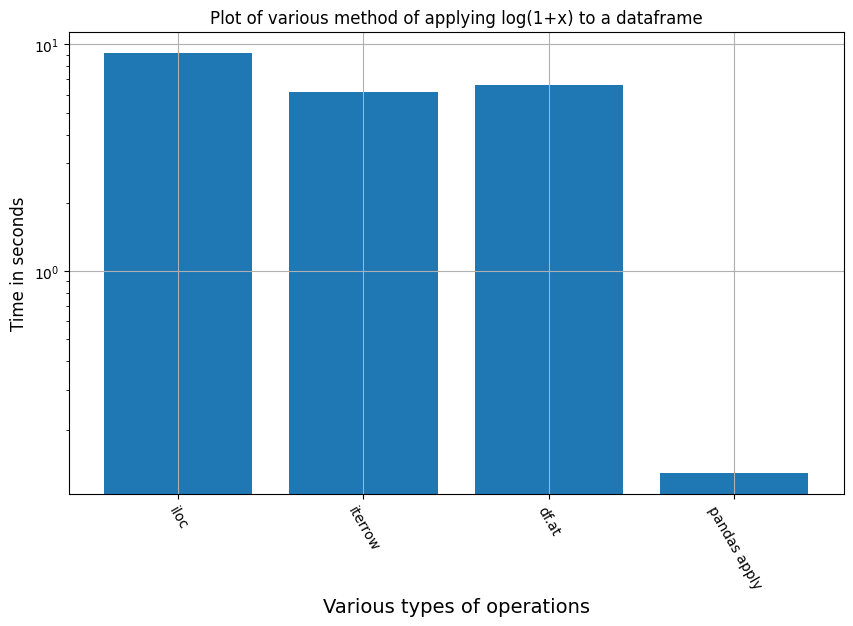

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Plot of various method of applying log(1+x) to a dataframe")
plt.ylabel("Time in seconds",fontsize=12)
plt.xlabel("Various types of operations",fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=-60)
plt.bar(x = range(len(timing)), height=timing.values(), align='center', tick_label=list(timing.keys()))
short = min(list(timing.values()))
long = max(list(timing.values()))
print('Speedup : {:4.0f} X'.format(long/short))

### WOW! 

Sped up a couple hundred times!

**Pandas.apply** is my new **best friend!**

# Alternative to Pandas Apply for Conditional Logic

Hmmm... But then we run into **conditional Logic** in our function. Hmmm. **Is Pandas Apply** still our **best friend?**

Below we create a randomly generated array of values to be included in a Pandas dataframe with a large number of rows

In [28]:
import pandas as pd 
import numpy as np
timing = {}
BIG = 4000000
df = pd.DataFrame(np.random.randint(0, 11, size=(BIG, 5)), columns=('a','b','c','d','e'))

Firsty of all, Pandas is built on Numpy - and we can demonstrate this by showing that under the hood when you look at values within a DataFrame, you will see the use of numpy.ndarray

In [29]:
type(df['a'].values)

numpy.ndarray

So how to best use the numpy that is built in?

Below we have a function with a lot of conditional logic that we want to applyu to the Entire Dataframe


In [30]:
def func(a,b,c,d,e):
    if e == 10:
        return c*d
    elif (e < 10) and (e>=5):
        return c+d
    elif e < 5:
        return a+b

Applying this function to the Dataframe, each row has to be evaluated for the condition and this makes the execution time slow because the conditional logic hinders can vectorization

### Naive Apply lambda on function with condition rows

In [31]:
import time
t1 = time.time()
df['new'] = df.apply(lambda x: func(x['a'], x['b'], x['c'], x['d'], x['e']), axis=1)
t2 = time.time()
print("time : {:5.2f}".format(t2-t1))
df.head()
timing['Pandas Apply'] = t2 - t1
baseTime = t2-t1

time : 56.01


This feels slow!

Can we do better?

### Use vectorization !

Here we will make use of Vectorization to create index masks that control the application of values to a given column - we operate on entire columns at a time this way. 

In [32]:
t1 = time.time()
df['new'] = df['c'] * df['d'] #default case e = =10
mask = (df['e'] < 10) & (df['e'] >= 5)
df.loc[mask,'new'] = df['c'] + df['d']
mask = df['e'] < 5
df.loc[mask,'new'] = df['a'] + df['b']
t2 = time.time()
print("time :", t2-t1)
df.head()
fastest_time = t2-t1
timing['Mask'] = t2 - t1
Speedup = baseTime / fastest_time
print("Speed up: {:4.0f} X".format(Speedup))

time : 0.26216721534729004
Speed up:  214 X


Speedup :  214 X


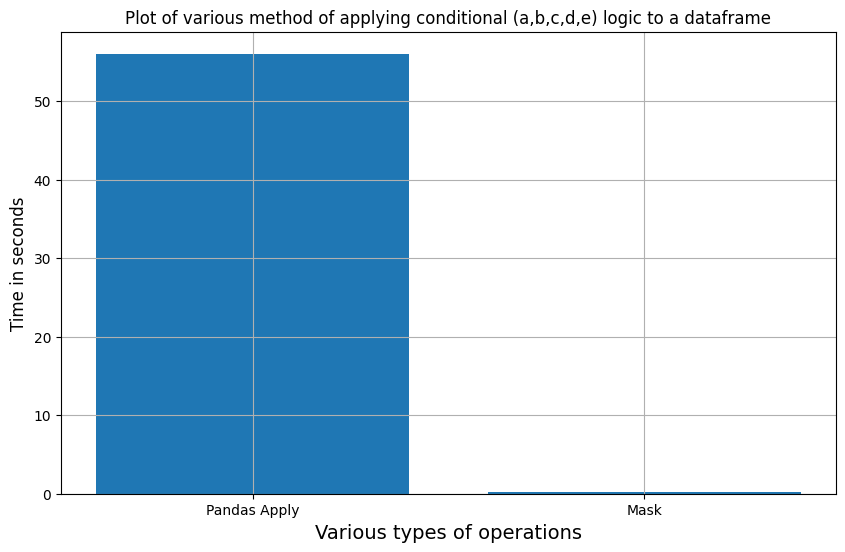

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Plot of various method of applying conditional (a,b,c,d,e) logic to a dataframe")
plt.ylabel("Time in seconds",fontsize=12)
plt.xlabel("Various types of operations",fontsize=14)
plt.grid(True)
plt.bar(x = range(len(timing)), height=timing.values(), align='center', tick_label=list(timing.keys()))
short = min(list(timing.values()))
long = max(list(timing.values()))
print('Speedup : {:4.0f} X'.format(long/short))

Well that feels much better!

over 100X speedup on DevCLoud (your milage may vary)

But the code looks complicated. The masking trick on Numpy arrays is effective but a little hard to read and debug

In [34]:
import pandas as pd 
BIG = 1000_000
timing = {}
df = pd.DataFrame(np.random.randint(0, 11, size=(BIG, 5)), columns=('a','b','c','d','e'))

### With Conditional Logic and Expensive Function!

In [35]:
def my_function(x):
    return np.log(1+x)

def func(a,b,c,d,e):
    if e == 10:
        return c*d
    elif (e < 10) and (e>=7):
        return my_function(c+d)
    elif e < 7:
        return my_function(a+b+100)

We confidently use our old Pandas "Apply" trick!

In [36]:
%%time
# naive loop method using pandas loc
import numpy as np

# each iteration of the loop requires an interpretation of the instructions being used and this decoding takes time
    
t1 = time.time()

df['new'] = df.apply(lambda x: func(x['a'], x['b'], x['c'], x['d'], x['e']), axis=1)

t2 = time.time()
print("time : {:5.2f}".format(t2-t1))
df.head()
baseTime = t2-t1
timing['Pandas Apply'] =  t2 - t1
df.head()

time : 13.86
CPU times: user 13.8 s, sys: 24 ms, total: 13.9 s
Wall time: 13.9 s


,a,b,c,d,e,new
0,9,8,0,10,8,2.397895
1,6,0,0,5,7,1.791759
2,5,9,5,1,7,1.945910
3,9,10,9,5,8,2.708050
4,0,5,10,0,0,4.663439


Hmmmm, I thought it would be faster - it vectorizes right?

Oh - conditional logic can hamper vectorization. 

Can I do something about it?

Maybe you read one time about a trick called masking. We will do the conditional logic to see an index or mask for our dataframe and use different masks for different conditions.

In [37]:
# masked approach
t1 = time.time()
df['new'] = df['c']  * df['d']  #default case e =10
mask = (df['e'] < 10) & (df['e'] >= 7)
df.loc[mask,'new'] = (df['c'] + df['d']).apply(lambda x : my_function(x))
mask = df['e'] < 7
df.loc[mask,'new'] = (df['a'] + df['b']).apply(lambda x : my_function(x + 100))
t2 = time.time()
print("time :", t2-t1)
fastest_time = t2-t1
Speedup = baseTime / fastest_time
print("Speed up: {:4.0f} X".format(Speedup))
timing['unrolled with masks on df'] = t2 - t1
df.head()

time : 2.633697748184204
Speed up:    5 X


,a,b,c,d,e,new
0,9,8,0,10,8,2.397895
1,6,0,0,5,7,1.791759
2,5,9,5,1,7,1.945910
3,9,10,9,5,8,2.708050
4,0,5,10,0,0,4.663439


WOW! Masking to the rescue!

Still - I wonder if I could do better?

I watched a cool video on Youtube by a guy introducing me to the **Numpy "Select" clause**. He had so many great tips - But off the top of my head I can remember the "Select" trick.

If you want to get serious about speeding up your python check these two references out!

Seriously - Look up Nathan Cheever talk [1000x faster data manipulation: vectorizing with Pandas and Numpy](https://www.youtube.com/watch?v=nxWginnBklU&t=237s).  His Advise is precient!

While you are at it - Look up Jake VanderPlas talk [Losing your Loops Fast Numerical Computing with NumPy](https://www.youtube.com/watch?v=EEUXKG97YRw). I also recommend that you buy his book [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/). 


Let's try  **Numpy "Select" clause** 

Notice that it cleans the code up alot!

1. You create a list of tuple containing your condition.

2. You create another list of tuples containg the opration you wish tou apply

3. You call np.select(condlist, choicelist, default=0)

**This cell will error - fix the error**

- Hint:

```python
condition = [ (df['e'] < 10) & (df['e'] >= 7),
              ( df['e'] < 7)]
choice = [ (df['c'] + df['d']).apply(lambda x : my_function(x) ), 
           (df['a'] + df['b']).apply(lambda x : my_function(x + 100) ) ]
default = (df['c'] * df['d'])
np.select(condition, choice, default = default )
```



In [38]:
# np.select(condlist, choicelist, default=0)
t1 = time.time()
################### add code here ###########
condition = [ (df['e'] < 10) & (df['e'] >= 7),
              ( df['e'] < 7)]
choice = [ (df['c'] + df['d']).apply(lambda x : my_function(x) ), 
           (df['a'] + df['b']).apply(lambda x : my_function(x + 100) ) ]
default = (df['c'] * df['d'])
np.select(condition, choice, default = default )
#############################################
np.select(condition, choice, default = default)
t2 = time.time()
print("time :", t2-t1)
timing['Numpy Select on Pandas df'] = t2 - t1
df.head()

time : 2.5980286598205566


,a,b,c,d,e,new
0,9,8,0,10,8,2.397895
1,6,0,0,5,7,1.791759
2,5,9,5,1,7,1.945910
3,9,10,9,5,8,2.708050
4,0,5,10,0,0,4.663439


Not bad. 

But, but I am using "numpy.select" and applying it to Pandas dataframes.

Could we speed it up more if we drop the Pandas and go completely with Numpy?

In [39]:
# Convert Pandas to numpy entirely
t1 = time.time()
npArr = df.to_numpy()  # convert to numpy
idx = {}  #intialize an indexing dictionary
for index, value in enumerate(df.columns):
    idx[value] = index
df.loc[:,'new'] = npArr[:,idx['c']] * npArr[:,idx['d']] #default case e =10
mask = (npArr[:,idx['e']] < 10) & (npArr[:,idx['e']] >= 7)
df.loc[mask,'new'] =  my_function(npArr[mask,idx['c']] + npArr[mask,idx['d']])
mask = (npArr[:,idx['e']] < 7)
df.loc[mask,'new'] = my_function(npArr[mask,idx['a']] + npArr[mask,idx['b']]  + 100)
t2 = time.time()
print("time :", t2-t1)
df.head()
fastest_time = t2-t1
Speedup = baseTime / fastest_time
print("Speed up: {:4.0f} X".format(Speedup))
timing['unrolled with Masks on dataframe'] = t2 - t1
df.head()

time : 0.07919692993164062
Speed up:  175 X


,a,b,c,d,e,new
0,9,8,0,10,8,2.397895
1,6,0,0,5,7,1.791759
2,5,9,5,1,7,1.945910
3,9,10,9,5,8,2.708050
4,0,5,10,0,0,4.663439


WOW!! Now we are talking - something over 60X speedup!

Code looks a little messy though.

How about if we try the Numpy.Select trick again?

This cell will error - fix the error

- Hint

```python
condition = [ (npArr[:,idx['e']] < 10) & (npArr[:,idx['e']] >= 7),
              (npArr[:,idx['e']] < 7)]

choice = [(my_function(npArr[:,idx['c']] + npArr[:,idx['d']]      )), 
          (my_function(npArr[:,idx['a']] + npArr[:,idx['b']] + 100))]

tmp = np.select(condition, choice, default= (npArr[:,idx['c']] * npArr[:,idx['d']]) )
```

In [40]:
# np.select(condlist, choicelist, default=0)
# Convert Pandas to numpy entirely
t1 = time.time()
npArr = df.to_numpy()  # convert to numpy

condition = xxx

choice = xxx

tmp = np.select(xxx)

df.loc[:,'new'] = tmp
t2 = time.time()

print("time :", t2-t1)

fastest_time = t2-t1
Speedup = baseTime / fastest_time
print("Speed up: {:4.0f} X".format(Speedup))
timing['Numpy Select Pure'] = t2 - t1
df.head()

NameError: name 'xxx' is not defined

### Plot the results

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title("Plot of various method of applying conditional (a,b,c,d,e) logic to a dataframe")
plt.ylabel("Log of speed up",fontsize=12)
plt.xlabel("Various types of operations",fontsize=14)
plt.grid(True)
plt.yscale('log')
plt.xticks(rotation=-60)
plt.bar(x = range(len(timing)), height=timing.values(), align='center', tick_label=list(timing.keys()))
short = min(list(timing.values()))
long = max(list(timing.values()))
print('Speedup : {:4.0f} X'.format(long/short))

WOW!!! Hundreds time faster than Pandas Apply AND code is cleaner!

SHIP IT!

In [ ]:
print("Done")